# Thử nghiệm hàm kích hoạt mới: Gaussian

In [1]:
import os
import random
import datetime
import time
import math
import subprocess
from glob import glob
import operator
import numpy as np
import pandas as pd
from collections import Counter

import scipy.stats as ss
from scipy import stats
from sklearn import preprocessing
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.compose import make_column_transformer
from sklearn.pipeline import Pipeline

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, mutual_info_regression
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, mean_absolute_error, mean_squared_error

import tensorflow as tf
from tensorflow.keras import backend as K
import keras

from tensorflow.keras.layers import Dense, Input, Dropout, Activation, BatchNormalization
from tensorflow.keras.models import Model, Sequential, load_model
from tensorflow.keras.callbacks import Callback, ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping, CSVLogger
from tensorflow.keras import initializers, regularizers, constraints, optimizers, layers
from tensorflow.keras.initializers import RandomNormal, Constant
from tensorflow.keras.metrics import Metric
import tensorflow.keras.optimizers as Optimizer
import tensorflow_addons as tfa 

import matplotlib.pyplot as plt
import seaborn as sns

import sys
import os.path as path
lib_path =  path.abspath(path.join('' ,"../../api/common"))
sys.path.insert(1, lib_path)
from transform_split_data import transform_split_data
from predict import predict, evaluate

%load_ext autoreload
%autoreload 2
%load_ext autotime
%load_ext tensorboard
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

time: 16 ms


- Khởi tạo phương thức giải phóng bộ nhớ gpu

In [2]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs
time: 1 s


## 1. Load data
- Load dữ liệu theo các option 

In [3]:
# Load dữ liệu
train_data = pd.read_csv('train_data_all.csv')
train_data

,race_id,KettoNum,id$Year,ChokyosiCode,BanusiCode,UM_BreederCode,Odds,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,...,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed
0,12135,2009100729,2011,1010,949030,600016,222,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.352506,-0.921203,0.090456,0.243086,59.833795
1,26439,2011103176,2015,1095,477030,100046,35,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.254953,-0.661138,-0.651838,-0.672843,58.230257
2,33661,2013100779,2017,1123,78006,703397,148,2.348416,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.206765,-0.442809,-1.241063,-0.613398,57.920792
3,28482,2011105992,2016,1129,547800,610012,52,1.378788,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.453573,-0.510523,-0.974169,-0.578217,60.876249
4,291,2004104307,2008,331,142006,701079,933,0.166752,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.477666,-1.938882,-0.988132,0.072652,57.627119
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,18201,2005106482,2013,1013,789006,400018,911,3.027155,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.232084,-0.467961,0.392597,3.096416,49.966265
475192,7309,2006102916,2010,1076,310007,393126,369,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-0.380029,0.211269,1.335489,-0.553954,60.301508
475193,16882,2007104657,2012,1102,103006,330314,63,-1.045283,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.541780,-1.376219,-0.335163,-0.299192,62.113587
475194,8963,2007104503,2010,221,100006,310390,109,-1.530097,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,-1.098465,-0.945524,-1.037796,-0.678908,60.050042


time: 12.7 s


In [4]:
# Load dữ liệu
test_data = pd.read_csv('test_data_all.csv')
test_data

,race_id,KettoNum,id$Year,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,...,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds,speed
0,34535,2015101022,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,0.398731,-0.216783,0.174543,-0.638874,58.064516
1,34535,2015103483,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.415822,-0.318228,-1.717806,4.068149,57.908847
2,34535,2015106010,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.351113,-2.011561,-0.232294,-0.547888,59.178082
3,34535,2015102342,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.812923,-0.653485,-1.837928,0.188494,58.775510
4,34535,2015102323,2018,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,...,0.0,0.0,0.0,0.0,0.0,-1.469803,-0.723257,-0.230315,-0.456902,57.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,35925,2014105425,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,0.252109,1.811460,1.335489,-0.671629,58.378378
19141,35925,2014105543,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,1.897933,2.023608,1.335489,-0.698319,57.857143
19142,35925,2011106130,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,-0.608380,0.873101,-1.450211,1.291248,57.754011
19143,35925,2012102418,2018,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,...,0.0,0.0,0.0,0.0,0.0,1.897933,0.945055,0.435675,-0.701958,57.497782


time: 547 ms


In [5]:
y_train_df = pd.read_csv('y_train_df_all.csv')
y_train_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2011,12135,2009100729,59.833795,72.20,1,1
1,2015,26439,2011103176,58.230257,105.10,1,1
2,2017,33661,2013100779,57.920792,161.60,11,0
3,2016,28482,2011105992,60.876249,130.10,2,1
4,2008,291,2004104307,57.627119,106.20,5,0
...,...,...,...,...,...,...,...
475191,2013,18201,2005106482,49.966265,207.50,13,0
475192,2010,7309,2006102916,60.301508,59.70,8,0
475193,2012,16882,2007104657,62.113587,69.55,6,0
475194,2010,8963,2007104503,60.050042,59.95,5,0


time: 359 ms


In [6]:
y_test_df = pd.read_csv('y_test_df_all.csv')
y_test_df

,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3
0,2018,34535,2015101022,58.064516,74.4,10,0
1,2018,34535,2015103483,57.908847,74.6,11,0
2,2018,34535,2015106010,59.178082,73.0,2,1
3,2018,34535,2015102342,58.775510,73.5,6,0
4,2018,34535,2015102323,57.142857,75.6,16,0
...,...,...,...,...,...,...,...
19140,2018,35925,2014105425,58.378378,111.0,1,1
19141,2018,35925,2014105543,57.857143,112.0,5,0
19142,2018,35925,2011106130,57.754011,112.2,6,0
19143,2018,35925,2012102418,57.497782,112.7,8,0


time: 47 ms


- Create X, y data

In [7]:
ref_col = ['ChokyosiCode', 'BanusiCode', 'UM_BreederCode', 'Odds']
drop_columns = ['race_id', 'KettoNum', 'id$Year', 'speed'] + ref_col
X_train = train_data.drop(drop_columns, axis=1)
X_train

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds
0,-1.045283,1.0,0.0,0.0,0.0,-1.550314,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.352506,-0.921203,0.090456,0.243086
1,0.166752,0.0,1.0,0.0,0.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.254953,-0.661138,-0.651838,-0.672843
2,2.348416,1.0,0.0,1.0,0.0,0.203121,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.206765,-0.442809,-1.241063,-0.613398
3,1.378788,1.0,0.0,1.0,0.0,1.079838,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.453573,-0.510523,-0.974169,-0.578217
4,0.166752,0.0,1.0,0.0,0.0,0.495360,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.477666,-1.938882,-0.988132,0.072652
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
475191,3.027155,0.0,0.0,0.0,0.0,-0.673597,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.232084,-0.467961,0.392597,3.096416
475192,-1.530097,0.0,1.0,0.0,0.0,-0.965836,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.380029,0.211269,1.335489,-0.553954
475193,-1.045283,1.0,0.0,1.0,0.0,0.495360,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.541780,-1.376219,-0.335163,-0.299192
475194,-1.530097,0.0,1.0,0.0,1.0,-1.258075,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.098465,-0.945524,-1.037796,-0.678908


time: 297 ms


In [8]:
y_train = train_data['speed']
y_train.describe()

count    475196.000000
mean         58.393319
std           2.308153
min          21.973550
25%          56.942004
50%          58.536585
75%          59.916782
max          66.666667
Name: speed, dtype: float64

time: 47 ms


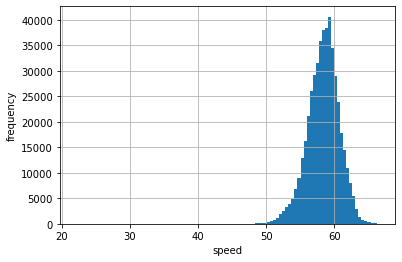

time: 469 ms


In [9]:
y_train.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

In [10]:
drop_columns = ['race_id', 'KettoNum', 'id$Year', 'speed']
X_test = test_data.drop(drop_columns, axis=1)
X_test

,Kyori,TenkoBaba$DirtBabaCD_0,TenkoBaba$SibaBabaCD_0,TenkoBaba$SibaBabaCD_1,TenkoBaba$DirtBabaCD_1,id$RaceNum,TrackCD_52,TrackCD_17,JyokenInfo$SyubetuCD_18,GradeCD_,...,KS_Syotai_フランス,KS_Syotai_川崎,KS_Syotai_笠松,id$JyoCD_1,KS_ChokyosiCode_365.0,CH_Syotai_川崎,top2_ChokyosiCode,top2_BanusiCode,top2_UM_BreederCode,before_Odds
0,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.398731,-0.216783,0.174543,-0.638874
1,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.415822,-0.318228,-1.717806,4.068149
2,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.351113,-2.011561,-0.232294,-0.547888
3,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.812923,-0.653485,-1.837928,0.188494
4,-1.045283,0.0,1.0,0.0,1.0,-1.550314,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-1.469803,-0.723257,-0.230315,-0.456902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19140,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.252109,1.811460,1.335489,-0.671629
19141,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.897933,2.023608,1.335489,-0.698319
19142,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,-0.608380,0.873101,-1.450211,1.291248
19143,0.409159,0.0,1.0,0.0,1.0,1.664316,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.897933,0.945055,0.435675,-0.701958


time: 32 ms


In [11]:
y_test = test_data['speed']
y_test.describe()

count    19145.000000
mean        58.013408
std          2.305421
min         38.876890
25%         56.509695
50%         58.142665
75%         59.558824
max         65.573770
Name: speed, dtype: float64

time: 0 ns


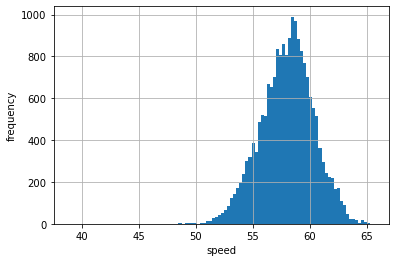

time: 328 ms


In [12]:
y_test.hist(bins=100);
plt.xlabel('speed');
plt.ylabel('frequency');

## 2. Train with ANN

- Create and compile Model

In [13]:
from tensorflow.keras import backend as K

def gaussian(x):
    return K.exp(-K.pow(x, 2))

def my_r2_score(y_true, y_pred):
    SS_res =  K.sum(K.square(y_true - y_pred)) 
    SS_tot = K.sum(K.square(y_true - K.mean(y_true) ) ) 
    return (1 - SS_res/(SS_tot + K.epsilon()) )

def BatchNorm():
    return BatchNormalization(
                momentum=0.95, 
                epsilon=0.005,
                beta_initializer=RandomNormal(mean=0.0, stddev=0.05), 
                gamma_initializer=Constant(value=0.9)
                )

#model.add(BatchNorm())
#model.add(Dropout(0.07))
#model.add(Dense(units=num_2, activation='relu'))
#model.add(BatchNorm())     

def build_and_compile_model(X_train, num_units=100, activation='sigmoid'):
    input_shape = X_train.shape[1] 
    model = Sequential()
    model.add(Dense(units=num_units, activation=activation, kernel_initializer='he_normal',
                    input_shape=(input_shape,)))
    model.add(Dense(1))
      
    model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError(), my_r2_score], optimizer=Optimizer.Adam(0.01)) #my_r2_score
    
    return model


time: 0 ns


- Setup callback

In [14]:
class My_checkoint(Callback):
        
    def __init__(self, model, X_test, y_test, checkpoint_name):
        self.X_test = X_test
        self.y_test = y_test
        self.mode = model
    def on_epoch_end(self, epoch, logs=None):
        cpn = checkpoint_name + format(epoch, '02d') + '-.hdf5'
        #cpn = os.path.join(checkpoint_dir, 'model'+format(epoch, '02d') + '-.hdf5')
        val_loss = self.mode.evaluate(self.X_test, self.y_test)
        print('my_val_loss', val_loss)
        self.mode.save(cpn)
        
def callback_model(model, checkpoint_name, logdir, X_test, y_test):
  
    _logdir = os.path.join(logdir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = TensorBoard(_logdir, histogram_freq=1)
    
    reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                  factor=0.3,
                                  patience=1,
                                  mode='min',
                                  verbose=1)
    
    early_stopping = EarlyStopping(patience=7,
                                   monitor='val_loss',
                                   mode='min',
                                   verbose=1)
    
    csv_logger = CSVLogger('log.log', separator=',', append=False)
    
    callbacks_list = [tensorboard_callback, reduce_lr, early_stopping, csv_logger, My_checkoint(model, X_test, y_test, checkpoint_name)]
    
    return callbacks_list


time: 0 ns


- Create train model

In [17]:
def train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir, batch_size=32, epochs=10, re_train=True):

    if re_train:
        # Clear old folder
        %rmdir /q/s {logdir}
        # Clear old file
        path = checkpoint_name + '**'
        all_path_files = glob(path)
        for file in all_path_files:
            os.remove(file)
        # fit model
        callbacks_list = callback_model(model, checkpoint_name, logdir, X_test, y_test)
        model.fit(X_train, y_train,
                  validation_data=(X_test, y_test),
                  batch_size=batch_size,
                  epochs=epochs,
                  callbacks=callbacks_list)
        
        #del model
        
    # Get best file by reading log file
    df = pd.read_csv('log.log')
    best_epoch = df.loc[df['val_loss']==df['val_loss'].min(), 'epoch'].values[0]
    best_file = 'model-' + format(best_epoch, '02d') + '-.hdf5'
    #best_file = os.path.join(checkpoint_dir, 'model'+format(best_epoch, '02d') + '-.hdf5')
    model = load_model(best_file, custom_objects={'my_r2_score': my_r2_score,
                                                                                 'gaussian': gaussian})
    return model


time: 0 ns


- <span style="color:blue">Train với bộ thông số tốt nhất trước khi cải tiến:
    - units: 275
    - batch_size: 128
    - activation: sigmoid
   

In [30]:
checkpoint_name = 'model-'
baseDir = os.path.abspath(os.getcwd())
logs_name = 'training_logs'
logdir = os.path.join(baseDir, logs_name)
#checkpoint_dir = os.path.join(baseDir, checkpoint_name)
model = build_and_compile_model(X_train, num_units=200, activation=gaussian)

model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                    batch_size=64, epochs=15, re_train=True)


Epoch 1/15
300/300 [==============================] - 1s 2ms/step - loss: 2.0627 - root_mean_squared_error: 1.4362 - my_r2_score: 0.1854
my_val_loss [2.06274676322937, 1.4362266063690186, 0.18540234863758087]
7425/7425 [==============================] - 22s 3ms/step - loss: 6.9052 - root_mean_squared_error: 2.6278 - my_r2_score: -0.4246 - val_loss: 2.0627 - val_root_mean_squared_error: 1.4362 - val_my_r2_score: 0.1854
Epoch 2/15
300/300 [==============================] - 1s 2ms/step - loss: 1.6530 - root_mean_squared_error: 1.2857 - my_r2_score: 0.3655
my_val_loss [1.6530492305755615, 1.2857096195220947, 0.3655342161655426]
7425/7425 [==============================] - 21s 3ms/step - loss: 1.4767 - root_mean_squared_error: 1.2152 - my_r2_score: 0.7125 - val_loss: 1.6530 - val_root_mean_squared_error: 1.2857 - val_my_r2_score: 0.3655
Epoch 3/15
7411/7425 [============================>.] - ETA: 0s - loss: 1.3880 - root_mean_squared_error: 1.1781 - my_r2_score: 0.7299
Epoch 00003: ReduceLR

KeyboardInterrupt: 

time: 1min 15s


- Evaluate model

In [19]:
# On train
train_result_df = evaluate(model, X_train, y_train_df)
#train_result_df

Sai số rmse:                    0.736
Hệ số xác định r2-score: 0.898
Tỉ lệ True positive:           0.412
time: 35.6 s


In [20]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)
#test_result_df

Sai số rmse:                    0.855
Hệ số xác định r2-score: 0.863
Tỉ lệ True positive:           0.382
time: 515 ms


- <span style="color:blue">Nhận xét:
    Hàm kích hoạt mới kém hơn

In [21]:
log_data = pd.read_csv('log.log')
log_data['epoch'] = log_data['epoch'] + 1
log_data

,epoch,loss,lr,my_r2_score,root_mean_squared_error,val_loss,val_my_r2_score,val_root_mean_squared_error
0,1,8.666882,1.000000e-02,-0.585802,2.943957,1.132825,0.705530,1.064343
1,2,1.048181,1.000000e-02,0.800541,1.023807,1.476352,0.614940,1.215052
2,3,0.678018,3.000000e-03,0.871873,0.823418,0.805324,0.792658,0.897398
3,4,0.659664,3.000000e-03,0.875399,0.812197,0.796801,0.795216,0.892637
4,5,0.646553,3.000000e-03,0.877985,0.804085,0.799723,0.795418,0.894272
5,6,0.574599,9.000000e-04,0.891769,0.758023,0.791060,0.796617,0.889415
6,7,0.565654,9.000000e-04,0.893476,0.752100,0.738551,0.809950,0.859390
7,8,0.561114,9.000000e-04,0.894334,0.749076,0.730463,0.811802,0.854671
8,9,0.556122,9.000000e-04,0.895359,0.745736,0.805891,0.789868,0.897714
9,10,0.532463,2.700000e-04,0.899704,0.729701,0.753456,0.805362,0.868018


time: 16 ms


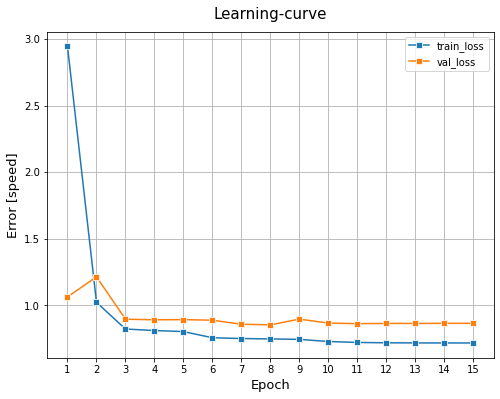

time: 375 ms


In [22]:
def plot_loss(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='root_mean_squared_error', data=log_data, marker='s', label='train_loss');
    sns.lineplot(x='epoch', y='val_root_mean_squared_error', data=log_data, marker='s', label='val_loss');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('Error [speed]', size=13)
    plt.legend()
    plt.title('Learning-curve', size=15, y=1.02)
    plt.grid(True)

plot_loss(log_data)

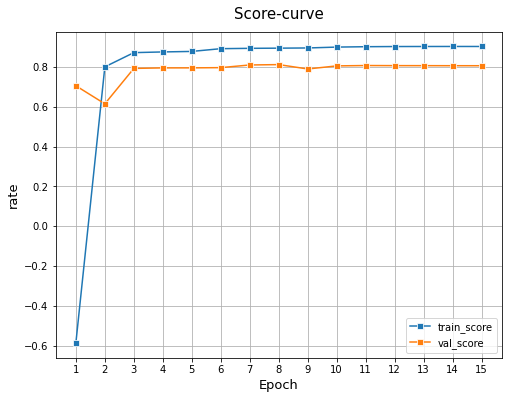

time: 391 ms


In [23]:
def plot_r2(log_data):
    plt.figure(figsize=(8, 6))
    #fig.add_subplot(1, 2, 1)
    sns.lineplot(x='epoch', y='my_r2_score', data=log_data, marker='s', label='train_score');
    sns.lineplot(x='epoch', y='val_my_r2_score', data=log_data, marker='s', label='val_score');
    plt.xlabel('Epoch', size=13)
    plt.xticks(np.arange(1, log_data['epoch'].max()+1, step=1))
    plt.ylabel('rate', size=13)
    plt.legend()
    plt.title('Score-curve', size=15, y=1.02)
    plt.grid(True)

plot_r2(log_data)

## 3. Tune parameter
- Điều chỉnh các siêu tham số bằng phương pháp BayesianOptimization

In [28]:
from kerastuner.tuners.bayesian import BayesianOptimization
from kerastuner import HyperModel

class RegressionHyperModel(HyperModel):
    
    def __init__(self, input_shape):
        self.input_shape = input_shape
        
    def build(self, hp):
        model = Sequential()
        model.add(
            Dense(
                units=hp.Int('units', 100, 300, 5, default=100),
                activation=hp.Choice(
                    'activation',
                    values=['gelu', 'sigmoid', 'tanh'],
                    default='sigmoid'),
                kernel_initializer='he_normal',
                input_shape=self.input_shape
            )
        )
        model.add(Dense(1))
        model.compile(loss='mse', metrics=[tf.keras.metrics.RootMeanSquaredError()],
                                           optimizer=Optimizer.Adam(0.01)) 
        return model
    
class MyTuner(BayesianOptimization):
    def run_trial(self, trial, *args, **kwargs):
        kwargs['batch_size'] = trial.hyperparameters.Int('batch_size', 16, 128, step=16)
        #kwargs['epochs'] = trial.hyperparameters.Int('epochs', 10, 20, 5)
        super(MyTuner, self).run_trial(trial, *args, **kwargs)    
        

time: 0 ns


In [29]:

input_shape = (X_train.shape[1], )
hypermodel = RegressionHyperModel(input_shape)
project_name = 'gaussian_search'

tuner = MyTuner(
            hypermodel,
            objective='val_loss',
            max_trials=10,
            executions_per_trial=2,
            seed=42,
            project_name=project_name,
            overwrite=True
            )
tuner.search(X_train, y_train, validation_data=(X_test, y_test), epochs=15, callbacks=[tf.keras.callbacks.EarlyStopping('val_loss', patience=3)], verbose=1)



Search: Running Trial #1

Hyperparameter    |Value             |Best Value So Far 
units             |230               |?                 
activation        |gelu              |?                 

Invalid model 0/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-28-5ec84f32ba3d>", line 12, in build
    Dense(
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\layers\core.py", line 1147, in __init__
    self.activation = activations.get(activation)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\activations.py", line 529, in get
    return deserialize(identifier)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\activati

Invalid model 1/5
Invalid model 2/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-28-5ec84f32ba3d>", line 12, in build
    Dense(
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\layers\core.py", line 1147, in __init__
    self.activation = activations.get(activation)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\activations.py", line 529, in get
    return deserialize(identifier)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\activati

Invalid model 3/5


Traceback (most recent call last):
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\kerastuner\engine\hypermodel.py", line 104, in build
    model = self.hypermodel.build(hp)
  File "<ipython-input-28-5ec84f32ba3d>", line 12, in build
    Dense(
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\layers\core.py", line 1147, in __init__
    self.activation = activations.get(activation)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\activations.py", line 529, in get
    return deserialize(identifier)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\util\dispatch.py", line 201, in wrapper
    return target(*args, **kwargs)
  File "C:\ProgramData\Anaconda3\envs\my_d2l\lib\site-packages\tensorflow\python\keras\activati

Invalid model 4/5
Invalid model 5/5


RuntimeError: Too many failed attempts to build model.

time: 1.36 s


- Get best hyperparameters

In [24]:
list_best_hp = tuner.get_best_hyperparameters(num_trials=3)
list_best_units = []
list_best_batch_size = []
list_best_activation = []

for best_hp in list_best_hp:
    best_units = best_hp.get('units')
    list_best_units.append(best_units)
    best_batch_size = best_hp.get('batch_size')
    list_best_batch_size.append(best_batch_size)
    best_activation = best_hp.get('activation')
    list_best_activation.append(best_activation)

hp_result = pd.DataFrame({'units':list_best_units,
                            'batch_size': list_best_batch_size,
                            'activation': list_best_activation
                            })
print('Các bộ tham số tốt nhất')
hp_result

Các bộ tham số tốt nhất


,units,batch_size,activation
0,180,112,sigmoid
1,145,96,sigmoid
2,190,80,sigmoid


time: 15 ms


- <span style="color:blue">Phương pháp:
    - Ta train lại 3 mô hình tốt nhất để đánh giá
   

In [25]:

list_val_loss = []
for num_units, activation, batch_size in zip(list_best_units, list_best_activation, list_best_batch_size):
    model = build_and_compile_model(X_train, num_units=num_units, activation=activation)
    model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                        batch_size=batch_size, epochs=15, re_train=True)
    val_loss, _, _ = model.evaluate(X_test, y_test)
    list_val_loss.append(val_loss)
    

Epoch 1/15
171/171 [==============================] - 0s 2ms/step - loss: 0.7374 - root_mean_squared_error: 0.8587 - my_r2_score: 0.7954
my_val_loss [0.7374114394187927, 0.8587266206741333, 0.7953792214393616]
4243/4243 [==============================] - 20s 5ms/step - loss: 11.9850 - root_mean_squared_error: 3.4619 - my_r2_score: -1.2797 - val_loss: 0.7374 - val_root_mean_squared_error: 0.8587 - val_my_r2_score: 0.7954
Epoch 2/15
4234/4243 [============================>.] - ETA: 0s - loss: 0.6467 - root_mean_squared_error: 0.8042 - my_r2_score: 0.8778
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
171/171 [==============================] - 0s 2ms/step - loss: 0.7409 - root_mean_squared_error: 0.8608 - my_r2_score: 0.7967
my_val_loss [0.7409430742263794, 0.8607804775238037, 0.7966784238815308]
4243/4243 [==============================] - 12s 3ms/step - loss: 0.6466 - root_mean_squared_error: 0.8041 - my_r2_score: 0.8778 - val_loss: 0.7409 - val_root_mea

In [26]:
improved_result = pd.DataFrame({'units':list_best_units,
                            'batch_size': list_best_batch_size,
                            'activation': list_best_activation,
                            'val_loss': list_val_loss})
improved_result

,units,batch_size,activation,val_loss
0,180,112,sigmoid,0.687983
1,145,96,sigmoid,0.707844
2,190,80,sigmoid,0.700511


time: 0 ns


In [27]:
# Save improve_result
improved_result.to_csv('improved_result.csv', index=False)

time: 15 ms


- <span style="color:blue">Ta chọn bộ tham số tốt nhất:
    - units: 180
    - batch_size: 112
    - activation: sigmoid
   

In [28]:
model = build_and_compile_model(X_train, num_units=180, activation='sigmoid')
model = train_model(model, X_train, y_train, X_test, y_test, checkpoint_name, logdir,
                        batch_size=112, epochs=15, re_train=True)
    

Epoch 1/15
171/171 [==============================] - 0s 2ms/step - loss: 0.6919 - root_mean_squared_error: 0.8318 - my_r2_score: 0.8086
my_val_loss [0.6919029951095581, 0.8318070769309998, 0.8085955381393433]
4243/4243 [==============================] - 14s 3ms/step - loss: 12.0107 - root_mean_squared_error: 3.4656 - my_r2_score: -1.3215 - val_loss: 0.6919 - val_root_mean_squared_error: 0.8318 - val_my_r2_score: 0.8086
Epoch 2/15
4231/4243 [============================>.] - ETA: 0s - loss: 0.6476 - root_mean_squared_error: 0.8047 - my_r2_score: 0.8776
Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
171/171 [==============================] - 0s 2ms/step - loss: 0.6994 - root_mean_squared_error: 0.8363 - my_r2_score: 0.8070
my_val_loss [0.6994108557701111, 0.8363078832626343, 0.8070346713066101]
4243/4243 [==============================] - 12s 3ms/step - loss: 0.6475 - root_mean_squared_error: 0.8047 - my_r2_score: 0.8776 - val_loss: 0.6994 - val_root_mea

- Evaluate model

In [29]:
# On train
train_result_df = evaluate(model, X_train, y_train_df)

Sai số rmse:                    0.817
Hệ số xác định r2-score: 0.875
Tỉ lệ True positive:           0.407
time: 27.1 s


In [30]:
# On test
test_result_df = evaluate(model, X_test, y_test_df)

Sai số rmse:                    0.832
Hệ số xác định r2-score: 0.870
Tỉ lệ True positive:           0.410
time: 422 ms


- <span style="color:blue">Nhận xét:
    - Đây là mô hình tốt nhất với kỹ thuật thêm biến mới 
   

## 4. Save best model 
- Lưu mô hình tốt nhất để triển khai API

In [31]:
# Save
model.save('improved_model.hdf5')

time: 47 ms


In [32]:
# Check
new_model = load_model('improved_model.hdf5', custom_objects={'my_r2_score': my_r2_score})
new_model

time: 63 ms


In [33]:
# On test
test = evaluate(new_model, X_test, y_test_df)
test

Sai số rmse:                    0.832
Hệ số xác định r2-score: 0.870
Tỉ lệ True positive:           0.410


,id$Year,race_id,KettoNum,speed,Time,KakuteiJyuni,top3,pred_speed,rank,top3_pred
0,2018,34535,2015104603,59.259259,72.90,1,1,58.376282,1,1
1,2018,34535,2015104342,58.695652,73.60,7,0,58.323719,2,1
2,2018,34535,2015101022,58.064516,74.40,10,0,58.159218,3,1
3,2018,34535,2015105549,59.016393,73.20,3,1,58.005974,4,0
4,2018,34535,2015103961,58.935880,73.30,4,0,57.844486,5,0
...,...,...,...,...,...,...,...,...,...,...
19140,2018,35925,2011104098,57.345133,113.00,9,0,56.821014,11,0
19141,2018,35925,2014101156,57.882983,111.95,4,0,56.752712,12,0
19142,2018,35925,2013105705,55.670103,116.40,15,0,56.709106,13,0
19143,2018,35925,2011106130,57.754011,112.20,6,0,56.639183,14,0


time: 516 ms
